In [273]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.subplots import make_subplots
import plotly.express as px

import missingno as msno

In [274]:
!pip install missingno

Defaulting to user installation because normal site-packages is not writeable


In [275]:
from sklearn import metrics

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV


from sklearn.metrics import r2_score, mean_absolute_error , mean_squared_error 
from sklearn.model_selection import cross_val_score


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


In [276]:
# LOADING THE DATA 
df = pd.read_csv('insurance.csv')

# 1. Understand the Data

In [277]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### The Dataset gives general information like:**
* There are lots of factors that cause for paying insurance ,Here are some factors that directly cause health insurance.
* **Age :**  Main fector 
* **Sex :** Insurance Contarctor gender : male , female
* **bmi :** Body mass index , shows a understanding of body , **idealy <BMI> 18 to 25** 
* **Children :** No of children covered in Insurance
* **Smoker :** is/not
* **Region :** Region wise benifiecery like Mumbai , delhi Kolkata , Banglore .

In [278]:
print('Number of rows and columns in the data set: ',df.shape)

Number of rows and columns in the data set:  (1338, 7)


In [279]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [280]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


<Figure size 500x200 with 0 Axes>

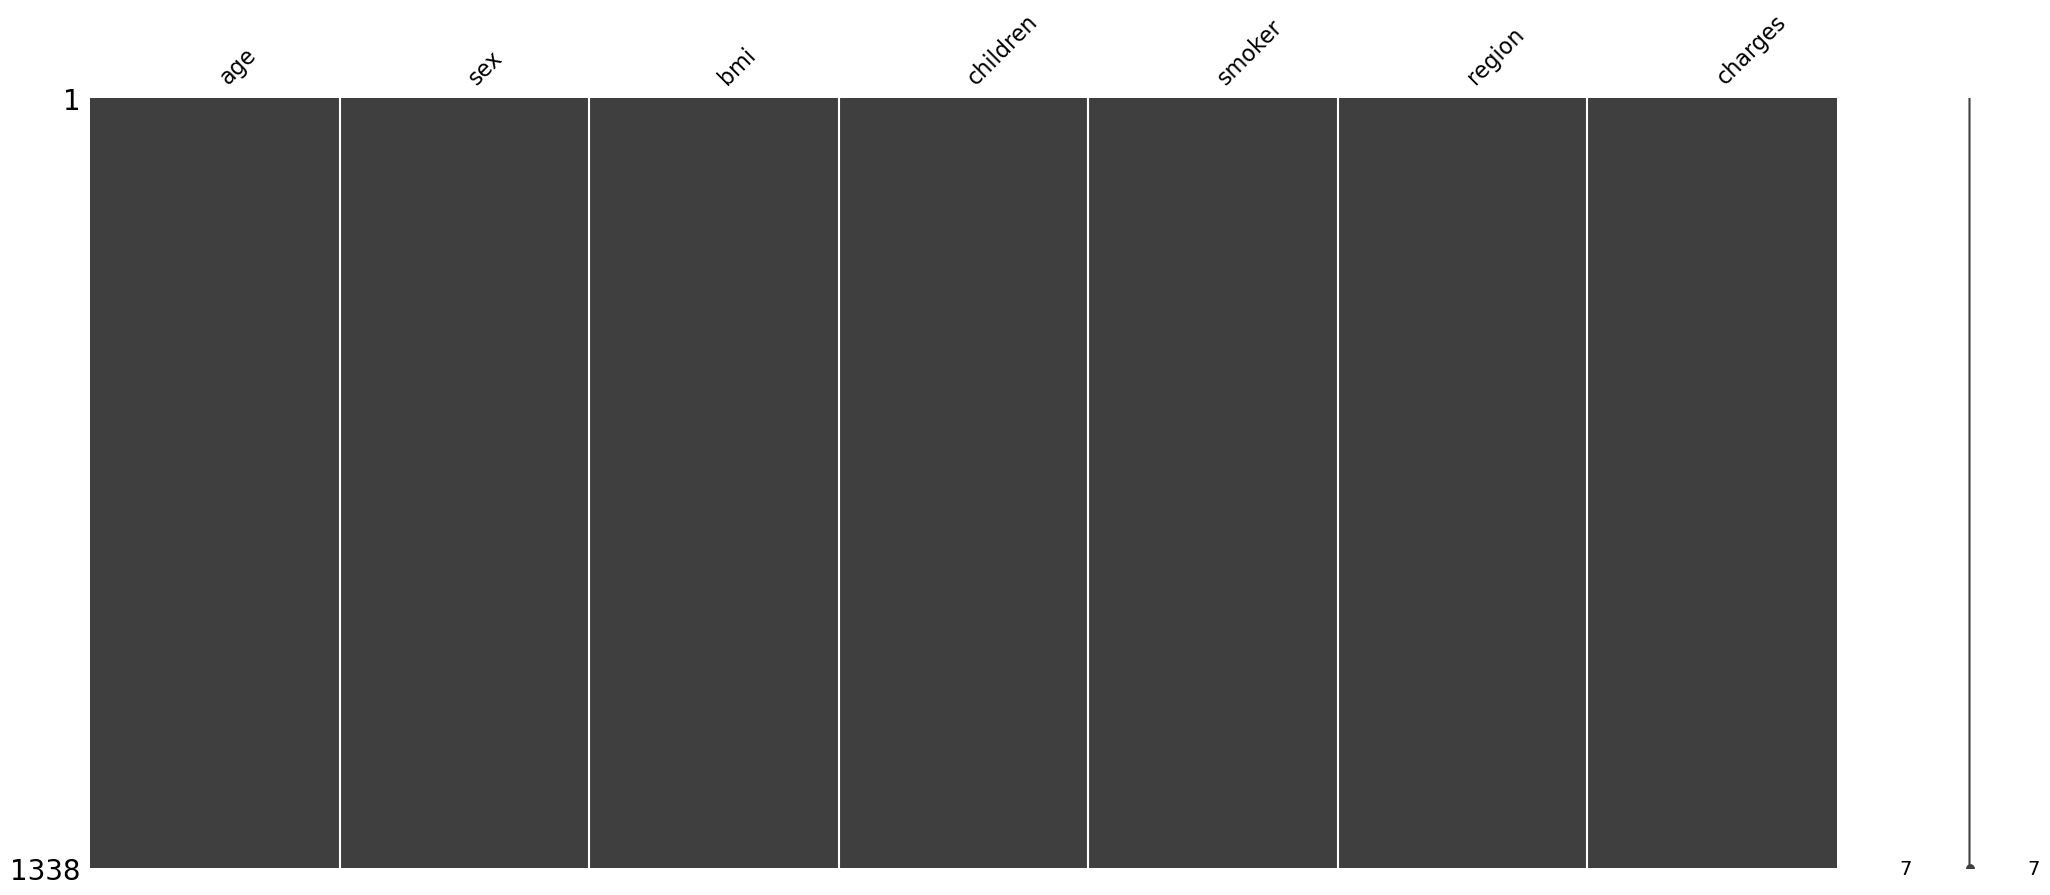

In [281]:
plt.figure(figsize=(5,2))
msno.matrix(df)
plt.show()

* We have 0 missing values which is very good. Now let's do EDA  First 

## 2 Visualization to Understand Data

***Corelation Btwn data***

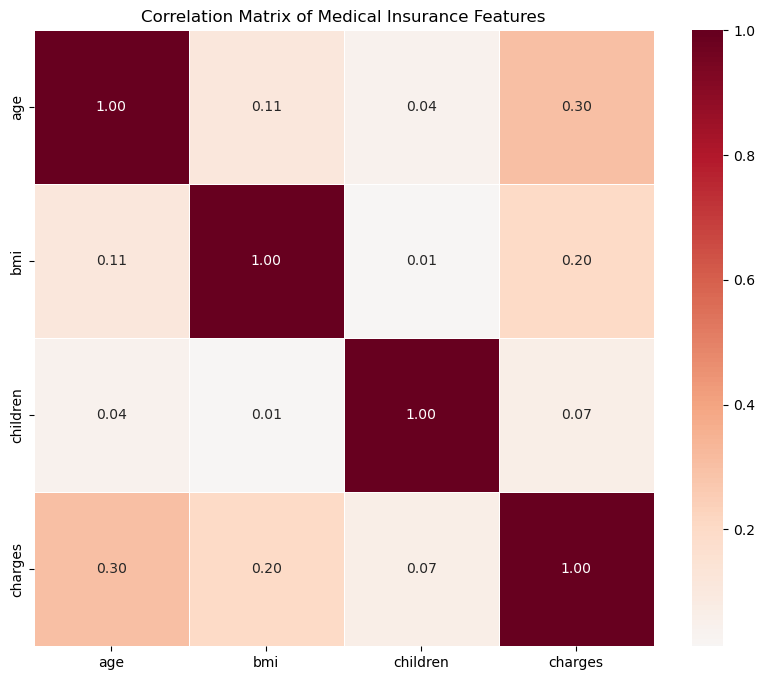

In [282]:

plt.figure(figsize=(10, 8))
corr = df.corr(numeric_only=True) # numeric_only avoids errors with text columns

sns.heatmap(corr, 
            annot=True, 
            fmt=".2f", 
            cmap='RdBu_r', 
            center=0,
            linewidths=0.5)

plt.title('Correlation Matrix of Medical Insurance Features')
plt.show()

* There is no Co-relation among variables . Its hard But lets check by one 

**Check Distribution Of Charges**

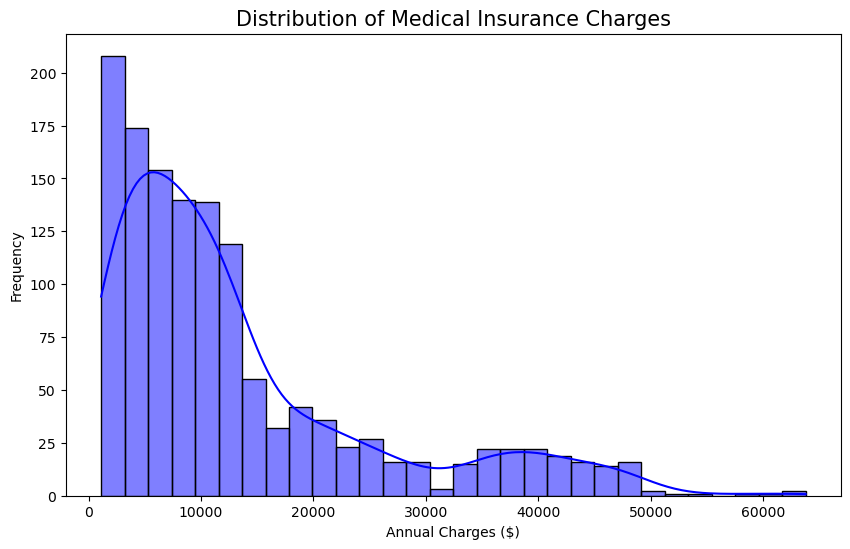

In [283]:
plt.figure(figsize=(10, 6))
sns.histplot(df['charges'], kde=True, color='blue', bins=30)

plt.title('Distribution of Medical Insurance Charges', fontsize=15)
plt.xlabel('Annual Charges ($)')
plt.ylabel('Frequency')
plt.show()

**If we look at the  plot the charges varies from 1000 to 60000, the plot is right skewed**
* Need to remove (Outlier)

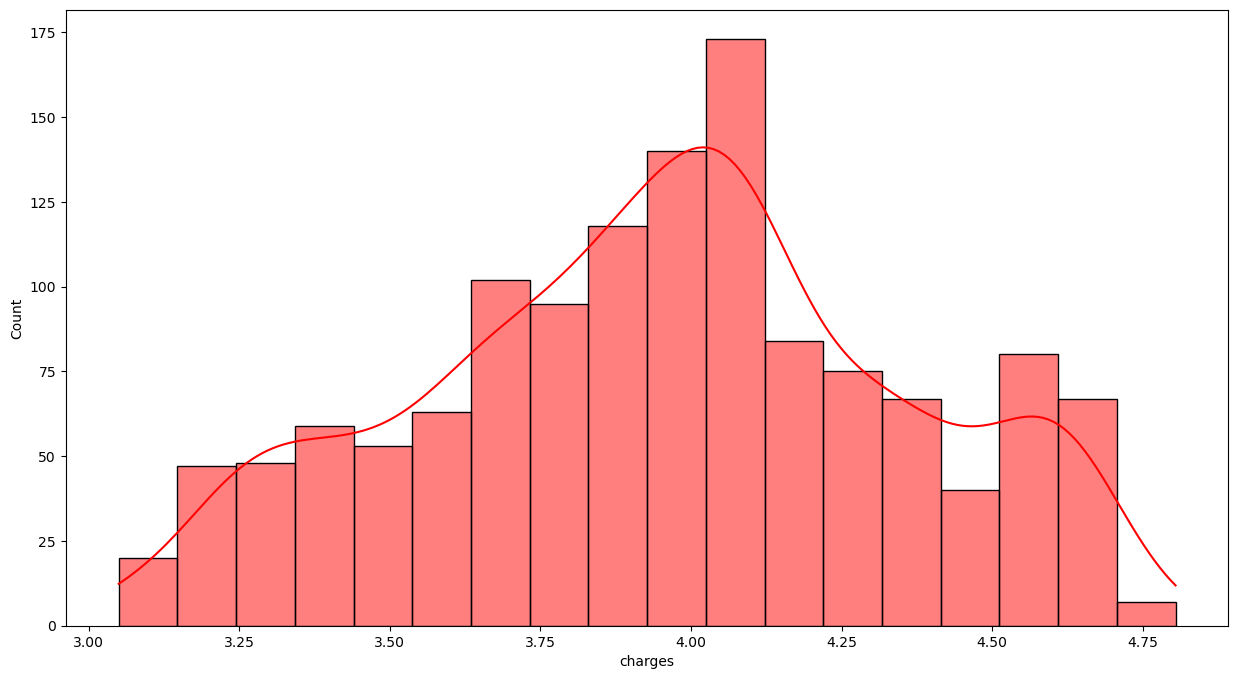

In [284]:
f, ax = plt.subplots(1, 1, figsize=(15, 8))
ax = sns.histplot(np.log10(df['charges']), kde = True, color = 'r' )
plt.show()

The 'Charges' data is likey very skewed . (Most people are very small amount few paying a lot) 
* The tallest peak  is around (4.0) The most common medical cost 
* the lowest peak is around (3.1) , lowest medical cost.

In [285]:
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


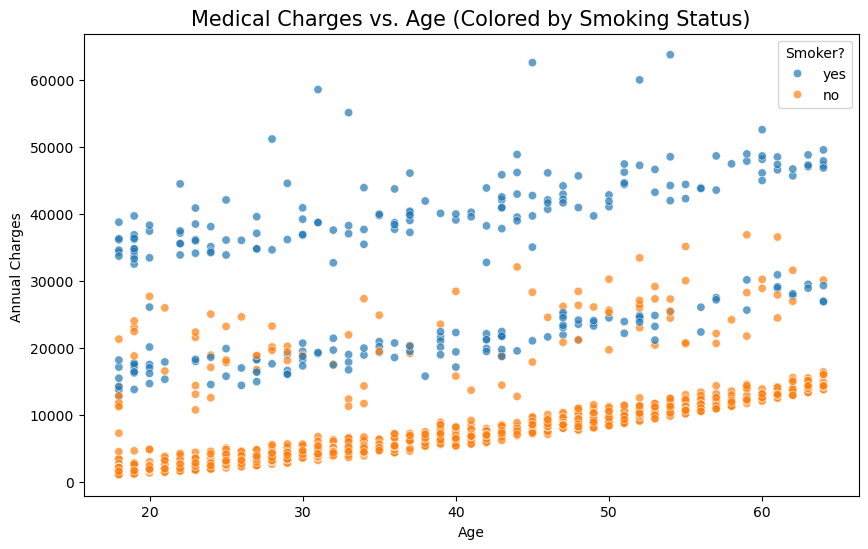

In [286]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='charges', data=df, hue='smoker', alpha=0.7)

plt.title('Medical Charges vs. Age (Colored by Smoking Status)', fontsize=15)
plt.xlabel('Age')
plt.ylabel('Annual Charges ')
plt.legend(title='Smoker?')
plt.show()

**Notice three distinct  layers of data**

* The bottom layer low Charges is non-smokers.

* The middle layer is often smokers with healthy BMIs.

* The top layer (most expensive) is smokers.


**Trend: You’ll see that as age increases, all three lines slope upward, confirming that age is a steady, linear driver of cost.**

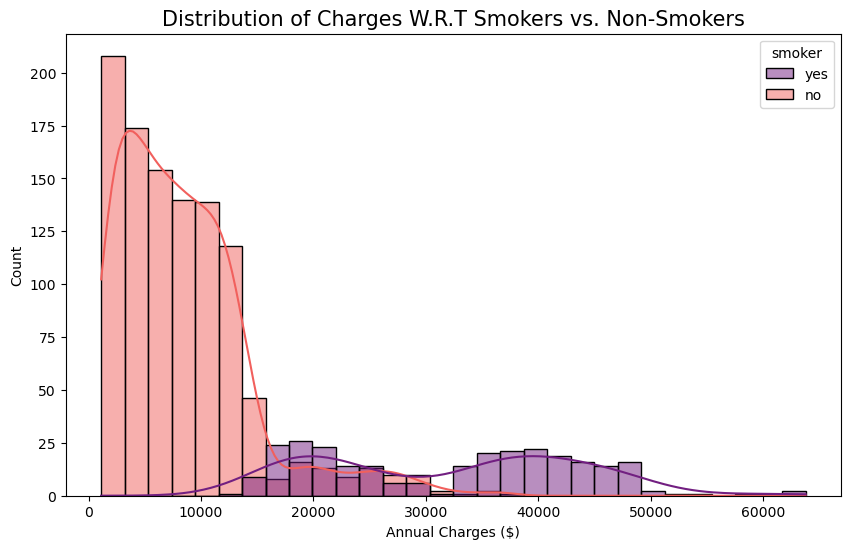

In [287]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='charges', hue='smoker', kde=True, palette='magma', bins=30)

plt.title('Distribution of Charges W.R.T Smokers vs. Non-Smokers', fontsize=15)
plt.xlabel('Annual Charges ($)')
plt.show()

* Notice that the "Non-Smoker" distribution ends almost exactly where the "Smoker" distribution begins. This proves smoker is a linearly separable feature.
* The non-smoker group is very "tight" , while the smoker group is  spread out (high variance).

**Smoking patients spend more on treatment. But there are  number of non-smoking patients is greater. Going to check it.**



In [288]:
age_18 = df[df['age'] == 18]                                                                           # Filter for only 18-year-olds

avg_costs = age_18.groupby('smoker')['charges'].mean()

print("Average Charges for 18-year-old:")
print(f"Non-Smokers: ${avg_costs['no']}")
print(f"Smokers:     ${avg_costs['yes']}")

# Calculate the 'Smoker Tax' multiplier
multiplier = avg_costs['yes'] / avg_costs['no']
print(f"\nSmokers at age 18 pay {multiplier:.1f}x more than non-smokers.")

Average Charges for 18-year-old:
Non-Smokers: $3215.1622585789473
Smokers:     $25473.73022083333

Smokers at age 18 pay 7.9x more than non-smokers.


C:\Users\hp\AppData\Local\Temp\ipykernel_21116\1744564086.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='sex', y='charges', palette=['#FF5733', '#33FF57'])


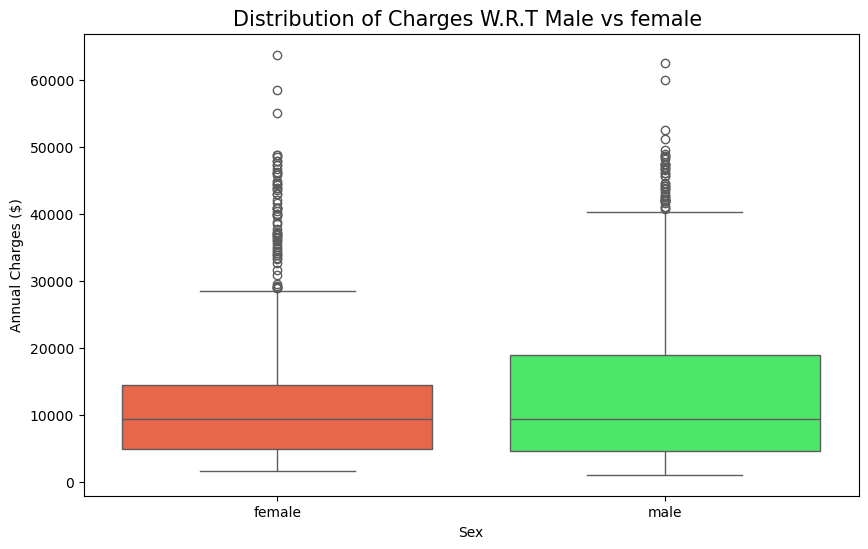

In [289]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='sex', y='charges', palette=['#FF5733', '#33FF57'])

plt.title('Distribution of Charges W.R.T Male vs female ', fontsize=15)
plt.ylabel('Annual Charges ($)')
plt.xlabel('Sex')

plt.show()

***The median Line  is at similar level for both males and females , its show
 avg charges are same for male and female.***
* MALE ARE  slighter wider range in cots in dataset
* black circle are paying more than the average .

***Sex is not Not  a factor of high charges***

In [290]:
df['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

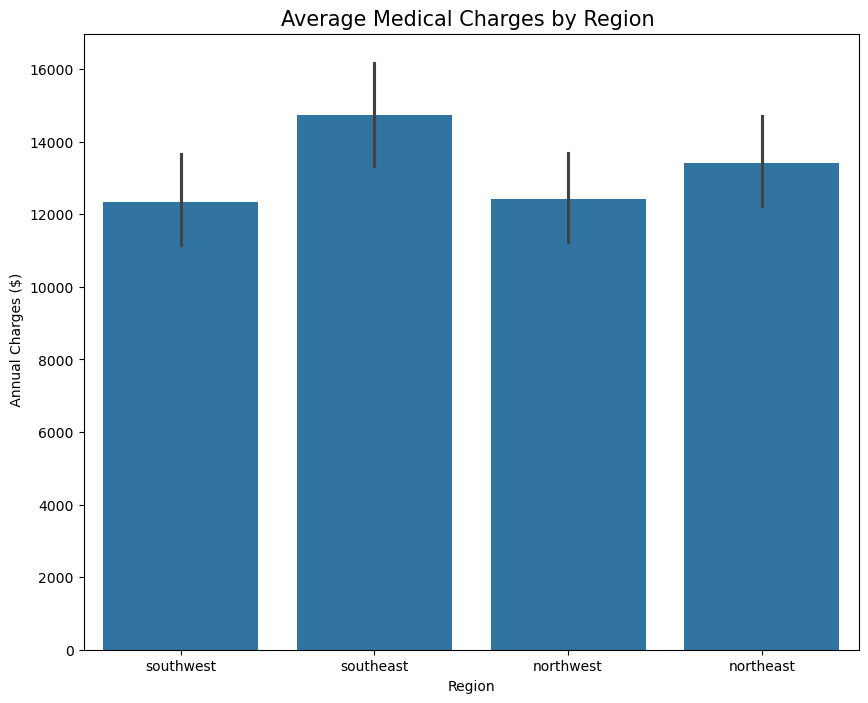

In [291]:
plt.figure(figsize=(10, 8))
sns.barplot(x='region', y='charges', data=df )

plt.title('Average Medical Charges by Region ', fontsize=15)
plt.xlabel('Region')
plt.ylabel(' Annual Charges ($)')
plt.show()

So overall the highest medical charges are in the Southeast and the lowest are in the Southwest. Taking into account certain factors  let's see how it changes by region

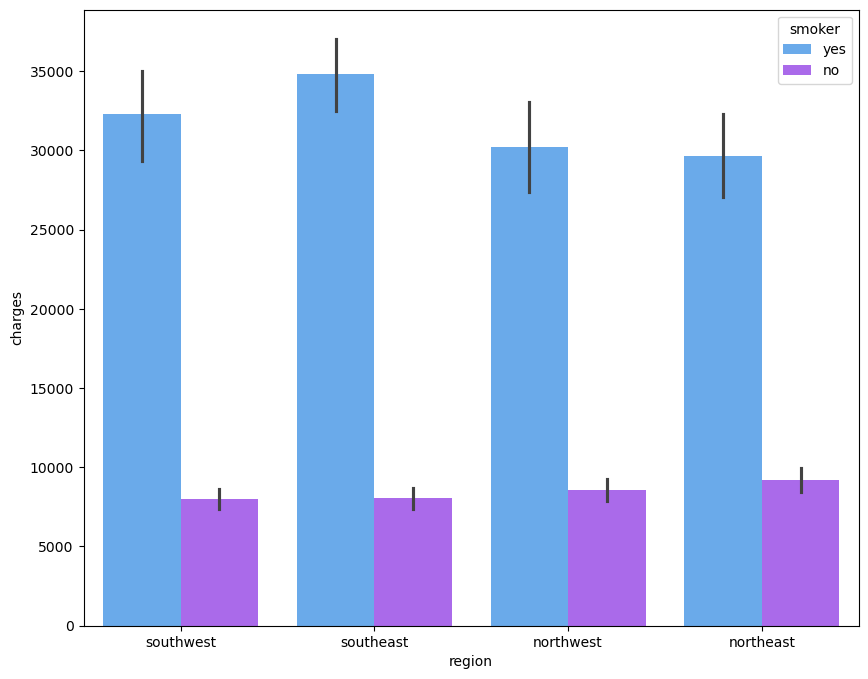

In [292]:
f, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = sns.barplot(x='region', y='charges', hue='smoker', data=df, palette='cool')
plt.show()

* Region not effect on smoking or not.
* Charges are also not vary w.r.t city . 
* A little jump in southwest

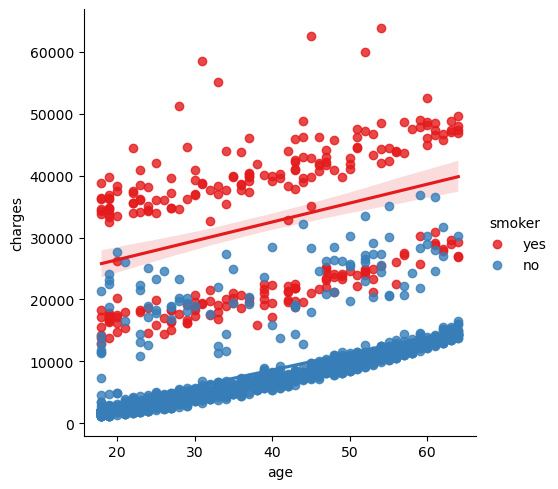

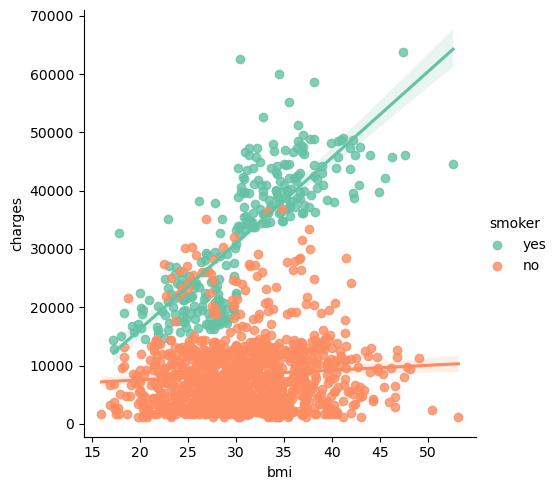

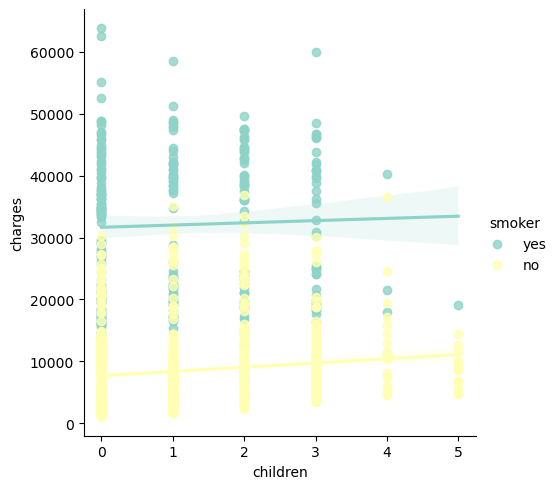

In [293]:
ax = sns.lmplot(x = 'age', y = 'charges', data=df, hue='smoker', palette='Set1')
ax = sns.lmplot(x = 'bmi', y = 'charges', data=df, hue='smoker', palette='Set2')
ax = sns.lmplot(x = 'children', y = 'charges', data=df, hue='smoker', palette='Set3')
plt.show()

**1-> plot 1  ,2-> plot->2 , 3 Plot->3**
* 1. In this people who smoke less are playing less charges | w.r.t age increses more paying

* 2. In this bmi is factor of high Charges , To Take care of health helps to low mediacal cost

* 3. children are  not smoking .

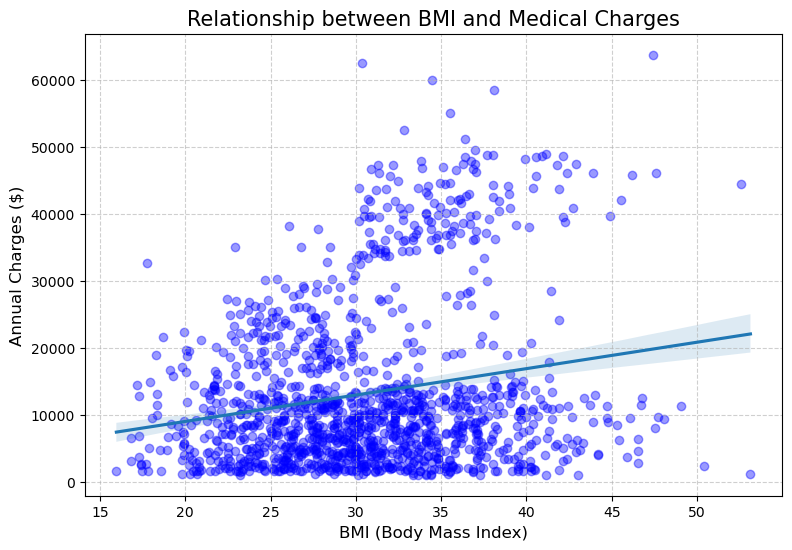

In [294]:
plt.figure(figsize=(9, 6))

sns.regplot(x='bmi', y='charges', data=df, 
            scatter_kws={'alpha':0.4, 'color':'blue'})

plt.title('Relationship between BMI and Medical Charges', fontsize=15)
plt.xlabel('BMI (Body Mass Index)', fontsize=12)
plt.ylabel('Annual Charges ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

**Positive Correlation:**
* The upward slope of the line confirms that as BMI increases, medical expenses generally rise. 
* In insurance terms, higher BMI equals higher financial risk.

**Clustering AT the Bottom:** 
*  Notice the thick band of points at the bottom (below $15,000). These are likely the non-smokers.
*  For this group, a higher BMI doesn't actually increase costs very much.

In [295]:
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


## Data preprocessing

* Machine learning model can not work directly with categorical Value data must convert into number  

**Label Encoding And One-Hot Encoding**

In [301]:
df_final = df.copy()

df_final['sex'] = df_final['sex'].map({'male': 1, 'female': 0})

df_final['smoker'] = df_final['smoker'].map({'yes': 1, 'no': 0})


df_final = pd.get_dummies(df_final, columns=['region'], drop_first=True, dtype=int)


print(df_final.dtypes)


age                   int64
sex                   int64
bmi                 float64
children              int64
smoker                int64
charges             float64
region_northwest      int32
region_southeast      int32
region_southwest      int32
dtype: object


***1.  Split Data***

* Split  data  into X and y Featurs -> X = Independent Data , y=Dependent Data 

In [302]:
X=df_final.drop('charges' , axis=1)

y=df_final['charges']

In [303]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state = 40, shuffle=True)



***------------Standardization---------***

In [305]:
scaler=StandardScaler()

X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

print("Preprocessing Complete!")
print(f"Training shape: {X_train_scaled.shape}")
print(f"Testing shape: {X_test_scaled.shape}")

Preprocessing Complete!
Training shape: (936, 8)
Testing shape: (402, 8)


### 1 Linear Regression

In [306]:
lr_model=LinearRegression()
lr_model.fit(X_train_scaled ,y_train)

y_pred =lr_model.predict(X_test_scaled)

In [308]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

performance_metric=pd.DataFrame({
 'Metric ': ['MAE' ,'MSE' ,'RMSE' ,'R^2'],
  'Value ': [mae ,mse ,rmse ,r2]
})
print(performance_metric.round(2).to_string(index=False))

Metric       Value 
    MAE     4355.95
    MSE 39424877.85
   RMSE     6278.92
    R^2        0.72


* Models Explain 72 %  **ACCURACY**  whcih is not so Good For Mediacl cost prediction. 
* RMSE > MAE : Shows large picture , RMSE finds large Errors more than MAE does , show model is making large errors 

In [309]:
mse_scores = cross_val_score(lr_model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-mse_scores)

r2_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5)


print(f"Average Error: ${rmse_scores.mean():,.2f}")

print(f"R^2 Scores Values for Every Validation : { r2_scores}")
print(f"Average Accuracy (R2): {r2_scores.mean():.2%}")

Average Error: $6,031.79
R^2 Scores Values for Every Validation : [0.79026464 0.74956763 0.80996628 0.69182194 0.71793407]
Average Accuracy (R2): 75.19%


***Insight***
**1 Model stablity and Reliablity**
* Avg. Accuracy improved , Which is better than intial 72 % .
* Gap btwn highest Score (80 %) and lowest score (69 %) its performance depends slightly on patients .

**RMSE VS MAE**
* RMSE also improved  during Cross-val score.

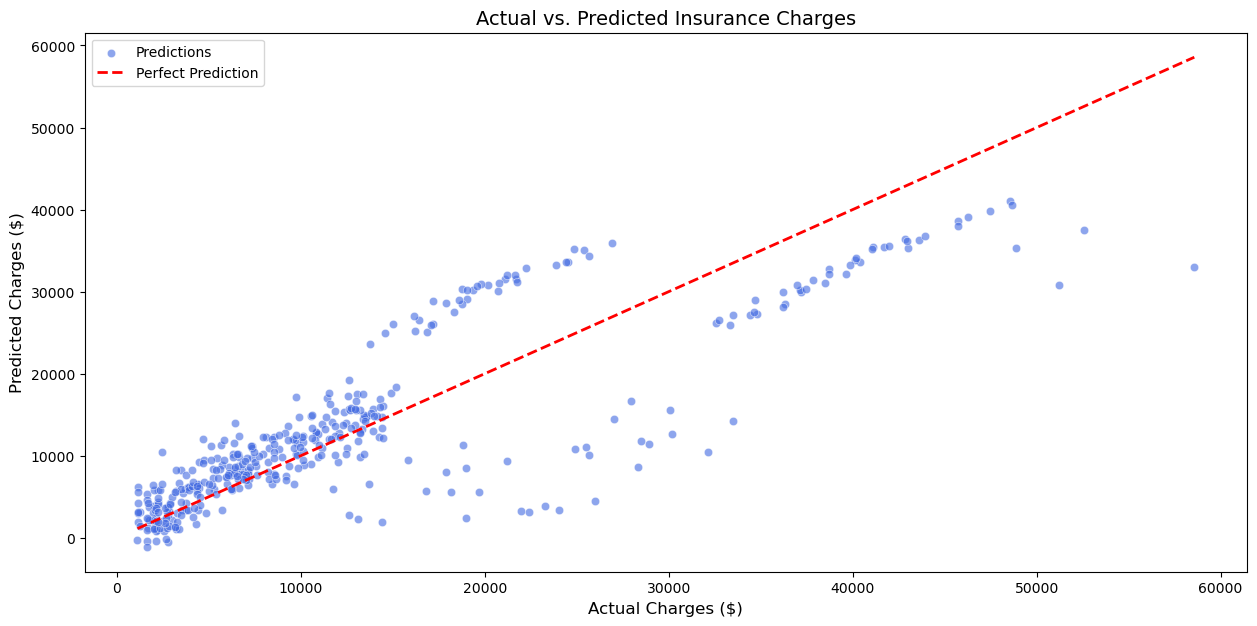

In [310]:
plt.figure(figsize=(15 ,7))

sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='royalblue', label='Predictions')

# The "Perfect Fit" Line
# We draw a diagonal line from the minimum to the maximum value.
# If every dot is on this line  model is 100% accurate.
line_coords = [y_test.min(), y_test.max()]
plt.plot(line_coords, line_coords, color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

plt.title('Actual vs. Predicted Insurance Charges', fontsize=14)
plt.xlabel('Actual Charges ($)', fontsize=12)
plt.ylabel('Predicted Charges ($)', fontsize=12)
plt.legend()
plt.show()

* **Under Prediction :**  Model under predicting  high insurance value greater than > 30K

* Figure shows That thre distinct clusters , They indicates hidden features such as **smoking  and BMI Categories**

* **Heteroscedasticty -> Variance increases with Charges**  prediction accurate for low cost , less reliable for expensive claims.


### 2 . Random Forest Regressor

**BASELINE MODEL-----------------> How the model Perform <--------------------But it tested only on specific slice of Data------>**

In [311]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

rf_y_pred = rf_model.predict(X_test_scaled)


rf_r2 = r2_score(y_test, rf_y_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_y_pred))

print(f"Random Forest R2 Score: {rf_r2:.4f}")
print(f"Random Forest RMSE: ${rf_rmse:,.2f}")

Random Forest R2 Score: 0.8183
Random Forest RMSE: $5,023.11


* **R^2 SCore : ->**          RF model explains 81 % of the variance in medical Charges .
* **RMSE :->**                Error shows 5023  $   its might significant improvement over the **Linear Regression**

**Cross -Validation -----------------> More Honest by testing on 5 diffrent folds <-----------testing on evry patient not Just luck---->**

In [312]:
rf_cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5)

print("Random Forest Mean R2:" ,rf_cv_scores)
print(f"Random Forest Mean R2: {rf_cv_scores.mean():.4f}")


Random Forest Mean R2: [0.87208393 0.8451228  0.88338519 0.78200898 0.81457163]
Random Forest Mean R2: 0.8394


* There are 5 R^2 score Value : Proves model Stablity and relialblity ..

* **Highest we  get R^2 score 88 %  and lowest we get 78 %**

* **MEAN VALUE of r^2 is : 83 % Improves from earler**

**GRID Search----------------> Best performance Optimization <---------------------->**

In [313]:
param_grid={
 'n_estimators' :[100 ,200,300],
 'max_depth' : [None,10,20 ],
  'min_samples_split': [2,5,10],
  'max_features': ['sqrt' ,'log2' ,None]
}
grid_search=GridSearchCV(
 estimator=RandomForestRegressor(random_state=42),
 param_grid=param_grid, 
 cv=5 ,
 scoring='r2' , 
 n_jobs=-1
 )

grid_search.fit(X_train_scaled ,y_train)

best_rf=grid_search.best_estimator_
print("Best Parameter :", grid_search.best_params_)
print("Best CV R^2 SCORE :", grid_search.best_score_)

Best Parameter : {'max_depth': 10, 'max_features': None, 'min_samples_split': 10, 'n_estimators': 200}
Best CV R^2 SCORE : 0.8557990274583283


**Here we get best perfromace value of R^2 and best parameter fro the model perfromance**
* R^2 score -85 % Accruacy best model as of now we get

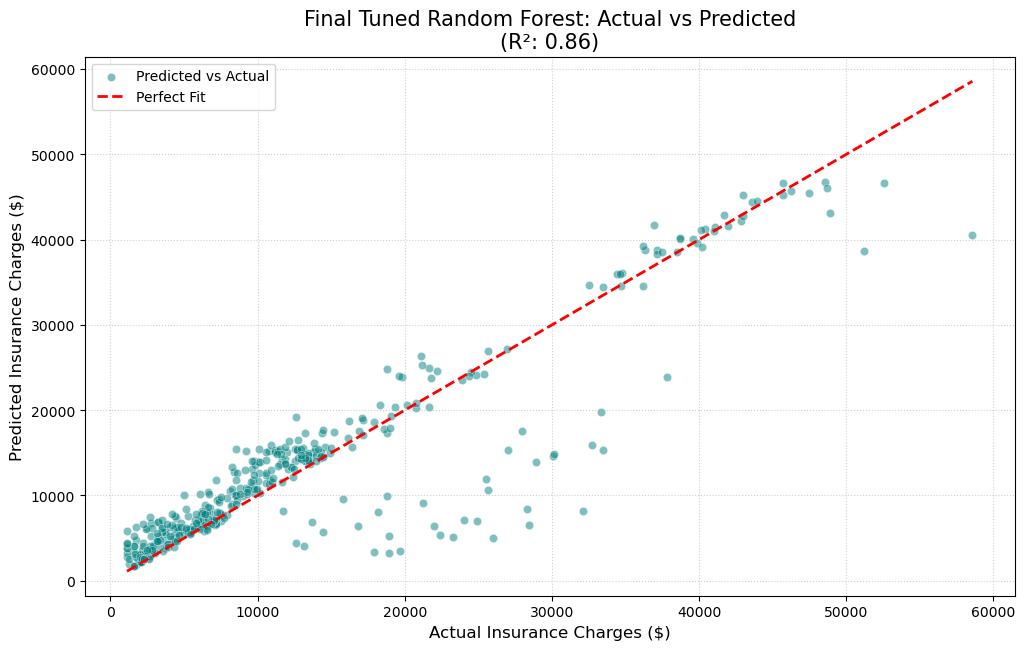

In [314]:
y_pred_best=best_rf.predict(X_test_scaled)

plt.figure(figsize=(12,7))

sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.5, color='teal', label='Predicted vs Actual')

# The "Perfect Prediction" Line (45-degree line)
# Any point on this line is a 100% perfect guess
line_coords = [y_test.min(), y_test.max()]
plt.plot(line_coords, line_coords, color='red', linestyle='--', lw=2, label='Perfect Fit')

# Customizing the labels
plt.title(f'Final Tuned Random Forest: Actual vs Predicted\n(R²: {grid_search.best_score_:.2f})', fontsize=15)
plt.xlabel('Actual Insurance Charges ($)', fontsize=12)
plt.ylabel('Predicted Insurance Charges ($)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)

plt.show()

***PLOT Analyzing***
* **Tight fit at low costs :** For Charges under 15K , model is accurate.Points are very close to red line .

* **High cost Variation :**  at 40k-60k range ,points are spread out , while model is better than linear ,are still hard to predict them 

* GAP pattern : there is no much data in the middle 

### 3. XGB Regressor Model

In [315]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

rmse=np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost R2 Score: {r2_score(y_test, y_pred_xgb):.4f}")

print(" RMSE : " ,rmse)

XGBoost R2 Score: 0.8007
 RMSE :  5261.3030874356045


In [316]:
xgb_param={
 'n_estimators' : [100,300,500],
 'max_depth' : [None,10,20] ,
 'learning_rate': [0.01, 0.05, 0.1],
 'subsample': [0.8, 1.0]
}

xgb_grid=GridSearchCV(
 estimator=XGBRegressor( random_state=42),
 param_grid=xgb_param,
 cv=5,
 n_jobs=-1,
 scoring='r2'
)


xgb_grid.fit(X_train_scaled ,y_train)

best_xgb=xgb_grid.best_estimator_
print("Best Parameter :"  ,xgb_grid.best_params_)
print("Final R^2 score :" ,xgb_grid.best_score_)



Best Parameter : {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 300, 'subsample': 0.8}
Final R^2 score : 0.8554840540624223


In [317]:
y_pred_xgb = best_xgb.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)

print(f"XGBoost RMSE: ${rmse:,.2f}")

XGBoost RMSE: $4,803.74


**Improved from bASE LINE XGB Model  80 % to 84 %,**



### Importance features for Random Forest MOdel 

C:\Users\hp\AppData\Local\Temp\ipykernel_21116\4111870060.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_importance, palette='viridis')


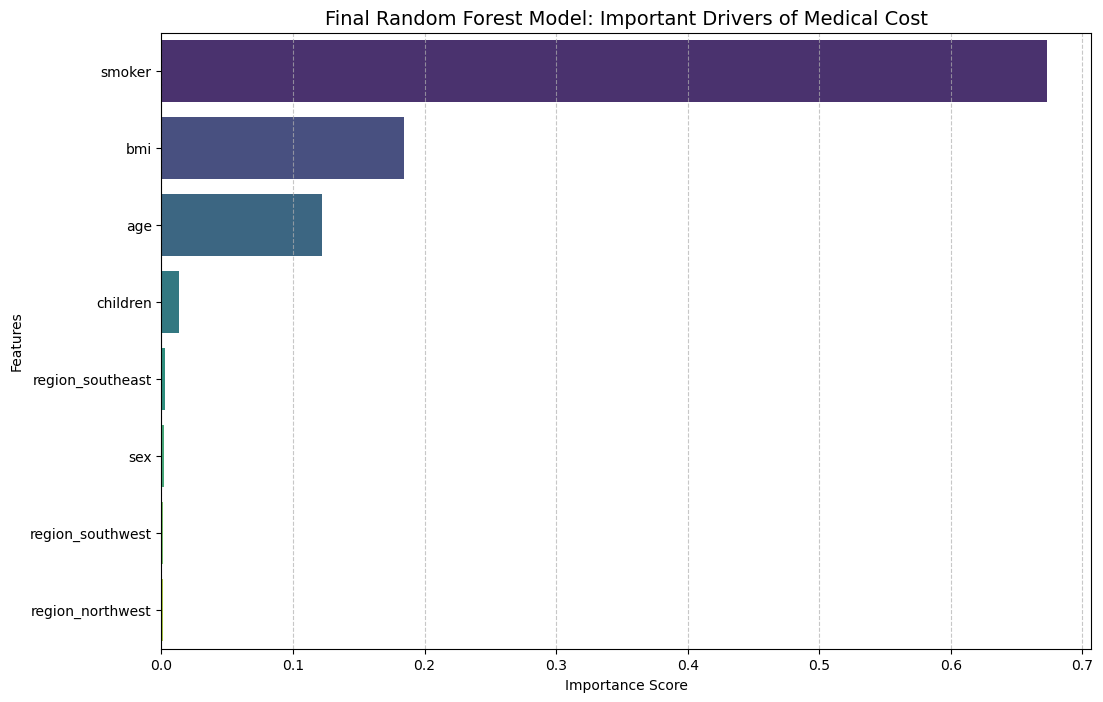

In [318]:
importances = best_rf.feature_importances_
feature_names = X_train.columns

df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False) 

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=df_importance, palette='viridis')

plt.title("Final Random Forest Model: Important Drivers of Medical Cost", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

##  ----------------------------------------Final Conclusion ---------------------------------------------------->

* **1. Model Evolution :** Started with Linear Regression (Baseline), moved to XGBoost, and finalized with Random Forest.
* **2. The Winning Metric :** Highlight  final R^2 Score of 0.855 , explaining that this model captures 85.5% of the variance in costs.
* **3. Cross-Validation :** I used 5-fold CV to ensure the model is stable and not overfit.
* **4. Top Driver (Smoking) :** State that Smoking Status is the most significant predictor of high medical costs.
* **5. Secondary Driver (BMI) :** Note that BMI, especially in the higher range, significantly increases predicted charges.
* **6. The "Gap" Insight:** Explain the "clusters" in the data (low-cost vs. high-cost) and how the Random Forest handled these non-linear patterns better than Linear Regression.
* **7. Bias-Variance Balance:** Choose Random Forest over XGBoost for its simplicity and stability, as both models achieved nearly identical scores.
* **8. Reliablity and Stablity :** Mention that  use of GridSearchCV to optimize hyperparameters like max_depth and min_samples_split.
* **9. Business Value:**Translate the numbers: "This model allows insurance providers to accurately estimate costs for 85% of cases, helping in risk assessment and premium setting."
